<a href="https://www.kaggle.com/code/mohamedbakrey/make-a-classification-for-tis-tweets-coved-19?scriptVersionId=92119232" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# load libraries
import numpy as np # linear algebra
import pandas as pd # data processing

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [2]:
train_df = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
test_df=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv")

In [3]:
# function to plot confusion matrix
def vis_conf_matrix(conf_martix, model_name):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_martix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_martix.flatten()/np.sum(conf_martix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _, ax = plt.subplots(figsize = (6,6))
    ax = sns.heatmap(conf_martix, annot=labels, fmt = '', 
                     annot_kws = {"size": 20, "weight": "bold"}, cmap = 'Blues')  
    labels = ['False', 'True']
    ax.set_title('Confusion Matrix for {}'.format(model_name), fontsize = 15)
    ax.set_xticklabels(labels, fontsize = 10)
    ax.set_yticklabels(labels, fontsize = 10)
    ax.set_xlabel('Prediction', fontsize = 15)
    ax.set_ylabel('Ground Truth', fontsize = 15)

# Label is the target columns

In [4]:
# Label is the target columns
train_df['label'] = train_df['Sentiment'].factorize()[0]
train_df['label'].nunique()

5

In [5]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,2


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Positive'),
  Text(1, 0, 'Negative'),
  Text(2, 0, 'Neutral'),
  Text(3, 0, 'Extremely Positive'),
  Text(4, 0, 'Extremely Negative')])

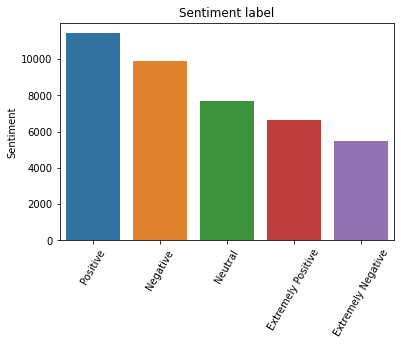

In [6]:
sns.barplot(x = train_df['Sentiment'].value_counts().index, 
            y = train_df['Sentiment'].value_counts()).set_title('Sentiment label')
plt.xticks(rotation = 60)

In [7]:
train_df.label.replace(to_replace = {'Extremely Positive' : 1, 'Positive' : 1, 'Neutral' : 1, 
                                   'Negative' : 0, 'Extremely Negative' : 0}, inplace=True)
train_df.label.unique()

array([0, 1, 2, 3, 4])

Text(0.5, 1.0, 'Sentiment label')

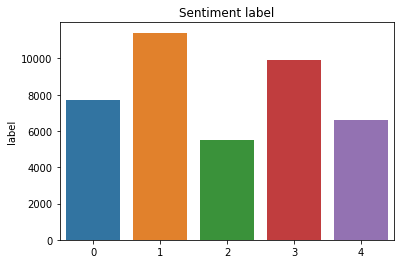

In [8]:
sns.barplot(x = train_df['label'].value_counts().index, 
            y = train_df['label'].value_counts()).set_title('Sentiment label')

In [9]:
# Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Lower casing
def lower(text):
    low_text = text.lower()
    return low_text

# Number removal
def remove_num(text):
    remove = re.sub(r'\d+', '' ,text)
    return remove
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str


train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_urls(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_html(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: lower(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: remove_num(x))
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: punctuation_removal(x))
#data.drop(columns = ['OriginalTweet'], inplace = True)

#### EDA: text length

array([[<AxesSubplot:title={'center':'len_char'}>]], dtype=object)

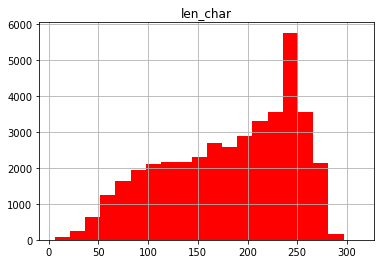

In [10]:
train_df['len_char'] = train_df.OriginalTweet.apply(lambda x: len(x))
train_df.hist(column = 'len_char', bins = 20,color='red')

## Stopword

In [11]:
def create_corpus(train_df, target_label, label_col = 'label', text_col = 'OriginalTweet'):
    corpus = []
    
    for x in train_df[train_df[label_col] == target_label][text_col].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# source: https://www.kaggle.com/code/datatattle/covid-19-tweets-eda-viz/notebook

In [12]:
corpus_pos = create_corpus(train_df, 1)
corpus_neg = create_corpus(train_df, 0)

print("Positives: ", len(corpus_pos))
print("Negatives: ", len(corpus_neg))

Positives:  338521
Negatives:  167395


### WordCloud

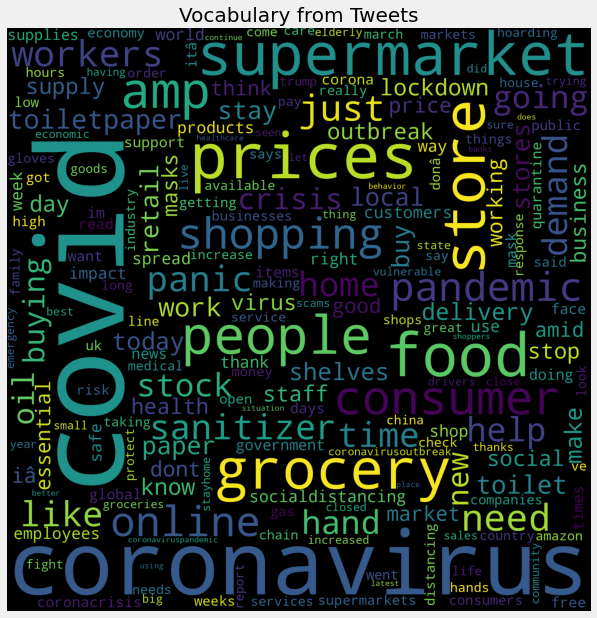

In [14]:
# lets plot the Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df['OriginalTweet'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Tweets", fontsize = 20)
plt.show()

# Using Deep Learning

In [15]:
pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3 MB 60 kB/s              
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 50 kB 5.7 MB/s             
     |████████████████████████████████| 449 kB 53.2 MB/s            
     |████████████████████████████████| 3.8 MB 51.0 MB/s            
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=5ca317804fd5a79525572f461f0b5a8bc93760c0ee03041ceb6bf73fc14ecf2d
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gas

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split


In [18]:
# Keeping only the neccessary columns
data = train_df[['OriginalTweet','label']]

In [27]:
max_fatures = 2000

tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['OriginalTweet'].values)
X = tokenizer.texts_to_sequences(data['OriginalTweet'].values)
X = pad_sequences(X, 28) 

Y = pd.get_dummies(data['label']).values

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)


In [21]:
print("The shape of train:",X_train.shape)
print("The shape of train:",X_test.shape)
print("The shape of train:",Y_train.shape)
print("The shape of train:",Y_test.shape)

The shape of train: (32925, 28)
The shape of train: (8232, 28)
The shape of train: (32925, 5)
The shape of train: (8232, 5)


In [45]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128,recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))

history=model.compile(loss = 'BinaryCrossentropy', optimizer='adam',metrics = ['accuracy'])


In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 28, 196)           254800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               166400    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 677,845
Trainable params: 677,845
Non-trainable params: 0
_________________________________________________________________


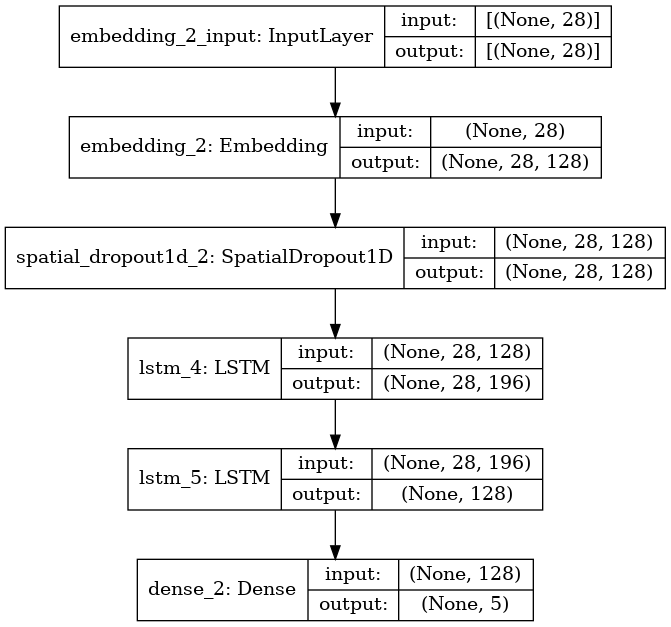

In [47]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

In [57]:
batch_size = 512

model.fit(X_train, Y_train, epochs = 100, batch_size=batch_size, validation_data=(X_test, Y_test))


Epoch 1/100
65/65 [==============================] - 14s 220ms/step - loss: 0.4271 - accuracy: 0.4312 - val_loss: 0.3885 - val_accuracy: 0.5104
Epoch 2/100
65/65 [==============================] - 15s 231ms/step - loss: 0.3651 - accuracy: 0.5584 - val_loss: 0.3524 - val_accuracy: 0.5807
Epoch 3/100
65/65 [==============================] - 15s 230ms/step - loss: 0.3387 - accuracy: 0.6089 - val_loss: 0.3457 - val_accuracy: 0.6056
Epoch 4/100
65/65 [==============================] - 15s 224ms/step - loss: 0.3278 - accuracy: 0.6317 - val_loss: 0.3435 - val_accuracy: 0.6139
Epoch 5/100
65/65 [==============================] - 15s 227ms/step - loss: 0.3210 - accuracy: 0.6416 - val_loss: 0.3370 - val_accuracy: 0.6181
Epoch 6/100
65/65 [==============================] - 15s 228ms/step - loss: 0.3167 - accuracy: 0.6516 - val_loss: 0.3329 - val_accuracy: 0.6274
Epoch 7/100
65/65 [==============================] - 15s 227ms/step - loss: 0.3128 - accuracy: 0.6562 - val_loss: 0.3320 - val_accuracy:

In [58]:
m1=model.save('h1')
m1

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f5b29898a70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [63]:
loss,accuracy=model.evaluate(X_train,Y_train)

1029/1029 [==============================] - 16s 15ms/step - loss: 0.0394 - accuracy: 0.9753


In [64]:
print(loss)
print(accuracy)

0.03944019973278046
0.9753075242042542
